In [ ]:
# Step 1: Install dependencies
!pip install torch torchvision matplotlib seaborn

# Step 2: Import libraries
import os
import zipfile
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Step 3: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 4: Extract dataset from /content/drive/MyDrive/food.zip
zip_path = "/content/drive/MyDrive/food_split.zip"
extract_dir = "food_dataset"

if os.path.exists(zip_path):  # Check if the file exists
    if not os.path.exists(extract_dir):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"✅ Extracted to ./{extract_dir}")
    else:
        print("✅ Already extracted!")
else:
    print(f"⛔ Error: File not found at {zip_path}")

# Step 5: Split into train/val/test
def split_dataset(src_dir, dest_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    assert train_ratio + val_ratio + test_ratio == 1.0
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(dest_dir, split), exist_ok=True)

    for class_name in os.listdir(src_dir):
        class_path = os.path.join(src_dir, class_name)
        if not os.path.isdir(class_path): continue
        images = os.listdir(class_path)
        random.shuffle(images)

        train_end = int(train_ratio * len(images))
        val_end = train_end + int(val_ratio * len(images))

        splits = {
            'train': images[:train_end],
            'val': images[train_end:val_end],
            'test': images[val_end:]
        }

        for split, files in splits.items():
            split_class_dir = os.path.join(dest_dir, split, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            for file in files:
                shutil.copy2(os.path.join(class_path, file), os.path.join(split_class_dir, file))

# Auto-detect if already split
# Auto-detect and handle already-split datasets
if os.path.exists(os.path.join(extract_dir, "train")) and \
   os.path.exists(os.path.join(extract_dir, "val")) and \
   os.path.exists(os.path.join(extract_dir, "test")):
    print("✅ Detected already split dataset. Renaming...")
    os.rename(extract_dir, "food_split")
else:
    print("🔄 Splitting dataset...")
   # split_dataset(extract_dir, "food_split")


# Step 6: Define transforms and load data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

data_dir = "/content/food_dataset/food_split"
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Step 7: Define model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(train_dataset.classes))
)
model = model.to(device)

# Step 8: Loss, Optimizer, Scheduler
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, x, target):
        log_probs = torch.nn.functional.log_softmax(x, dim=-1)
        nll = -log_probs.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1)
        smooth = -log_probs.mean(dim=-1)
        return ((1 - self.smoothing) * nll + self.smoothing * smooth).mean()

criterion = LabelSmoothingCrossEntropy()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=200)

# Step 9: Training Loop with Early Stopping
num_epochs = 100
early_stop_patience = 5
best_val_loss = float("inf")
patience_counter = 0

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(100 * correct / total)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            scheduler.step(loss)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Acc={train_accs[-1]:.2f}% | Val Loss={val_losses[-1]:.4f}, Acc={val_accs[-1]:.2f}%")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "/content/resnet50_best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("⛔ Early stopping triggered")
            break

print("✅ Training complete. Model saved to /content/resnet50_best_model.pth")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Already extracted!
🔄 Splitting dataset...
✅ Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1: Train Loss=4.3853, Acc=1.30% | Val Loss=4.3521, Acc=2.71%


Epoch 2: Train Loss=4.2877, Acc=4.91% | Val Loss=4.1754, Acc=16.91%


Epoch 3: Train Loss=4.0132, Acc=17.69% | Val Loss=3.7781, Acc=28.81%


Epoch 4: Train Loss=3.5967, Acc=27.15% | Val Loss=3.3326, Acc=35.70%


Epoch 5: Train Loss=3.1707, Acc=35.95% | Val Loss=2.9571, Acc=43.63%


Epoch 6: Train Loss=2.8379, Acc=43.90% | Val Loss=2.6836, Acc=54.07%


Epoch 7: Train Loss=2.5860, Acc=49.75% | Val Loss=2.5150, Acc=53.44%


Epoch 8: Train Loss=2.3723, Acc=55.25% | Val Loss=2.3525, Acc=54.91%


Epoch 9: Train Loss=2.1677, Acc=62.04% | Val Loss=2.2149, Acc=59.29%


Epoch 10: Train Loss=1.9974, Acc=66.77% | Val Loss=2.1492, Acc=62.42%


Epoch 11: Train Loss=1.8595, Acc=70.39% | Val Loss=2.0707, Acc=61.38%


Epoch 12: Train Loss=1.7669, Acc=73.60% | Val Loss=2.0222, Acc=62.63%


Epoch 13: Train Loss=1.6268, Acc=77.31% | Val Loss=1.9788, Acc=62.63%


Epoch 14: Train Loss=1.5420, Acc=79.59% | Val Loss=1.9708, Acc=62.42%


Epoch 15: Train Loss=1.4852, Acc=82.80% | Val Loss=1.9201, Acc=63.05%


Epoch 16: Train Loss=1.3970, Acc=84.73% | Val Loss=1.8819, Acc=63.67%


Epoch 17: Train Loss=1.3508, Acc=85.80% | Val Loss=1.8813, Acc=63.05%


Epoch 18: Train Loss=1.2772, Acc=90.00% | Val Loss=1.8755, Acc=65.76%


Epoch 19: Train Loss=1.2182, Acc=90.22% | Val Loss=1.8513, Acc=66.18%


Epoch 20: Train Loss=1.1776, Acc=92.14% | Val Loss=1.8796, Acc=65.97%


Epoch 21: Train Loss=1.1428, Acc=92.76% | Val Loss=1.8496, Acc=66.60%


Epoch 22: Train Loss=1.1001, Acc=94.46% | Val Loss=1.8894, Acc=66.60%


Epoch 23: Train Loss=1.0601, Acc=95.49% | Val Loss=1.8792, Acc=67.43%


Epoch 24: Train Loss=1.0473, Acc=95.62% | Val Loss=1.8735, Acc=65.76%


Epoch 25: Train Loss=1.0337, Acc=96.25% | Val Loss=1.9002, Acc=66.81%


Epoch 26: Train Loss=1.0184, Acc=96.11% | Val Loss=1.8723, Acc=65.97%
⛔ Early stopping triggered
✅ Training complete. Model saved to /content/resnet50_best_model.pth


In [2]:
# Fine-tuning after early stopping - FIXED VERSION

# Step 1: Reload the best model
model.load_state_dict(torch.load("/content/resnet50_best_model.pth"))
model = model.to(device)

# Step 2: Adjust training parameters for fine-tuning
# Get all parameters except the final layer (fc)
base_params = [p for n, p in model.named_parameters() if not n.startswith('fc')]
fc_params = [p for n, p in model.named_parameters() if n.startswith('fc')]

# Create optimizer with different learning rates
optimizer = optim.Adam([
    {'params': base_params, 'lr': 1e-5},  # Lower learning rate for base layers
    {'params': fc_params, 'lr': 1e-4}     # Higher learning rate for final layers
], weight_decay=1e-4)

# Use a simpler scheduler for fine-tuning
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# Step 3: Fine-tuning loop
num_finetune_epochs = 20
best_val_loss = min(val_losses)  # Start with previous best
patience_counter = 0

print("\nStarting fine-tuning...")

for epoch in range(num_finetune_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    loop = tqdm(train_loader, desc=f"Fine-tune Epoch {epoch+1}/{num_finetune_epochs}", leave=False)

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step(val_loss)  # Update learning rate based on validation loss

    print(f"Fine-tune Epoch {epoch+1}: Train Loss={train_loss:.4f}, Acc={train_acc:.2f}% | Val Loss={val_loss:.4f}, Acc={val_acc:.2f}%")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "/content/resnet50_finetuned_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("⛔ Fine-tuning early stopping triggered")
            break

print("✅ Fine-tuning complete. Model saved to /content/resnet50_finetuned_model.pth")

NameError: name 'model' is not defined

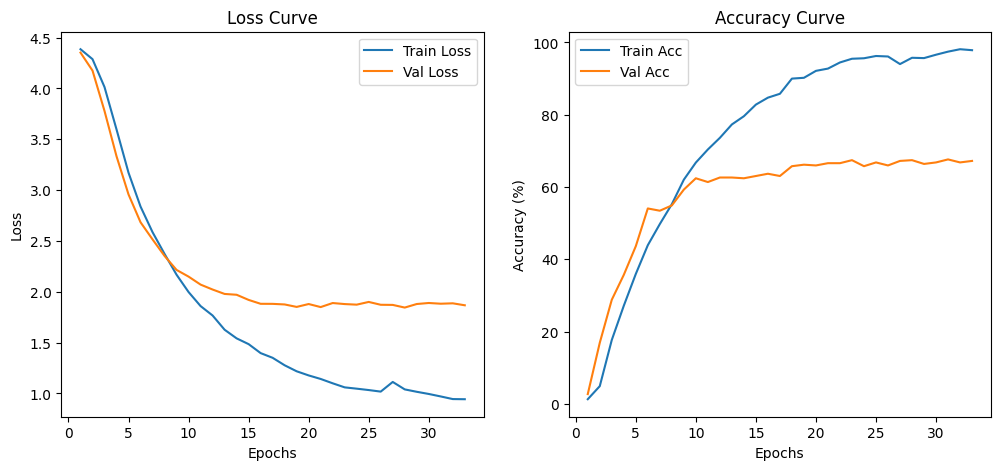

In [ ]:

# Plot accuracy and loss curves
# Plot accuracy and loss curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
epochs_completed = len(train_losses)  # Get actual number of completed epochs
plt.plot(range(1, epochs_completed+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs_completed+1), val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(range(1, epochs_completed+1), train_accs, label="Train Acc")
plt.plot(range(1, epochs_completed+1), val_accs, label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy Curve")
plt.show()


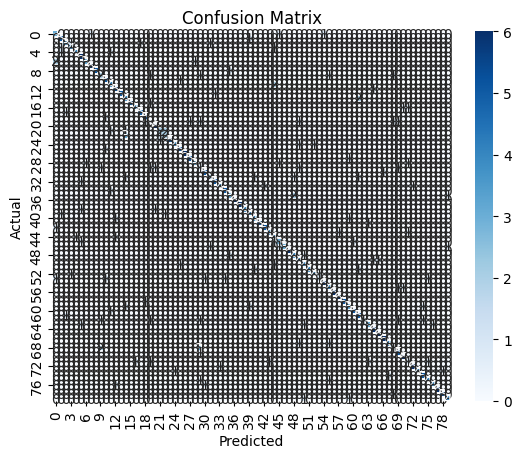

              precision    recall  f1-score   support

           0       0.43      0.50      0.46         6
           1       0.62      0.83      0.71         6
           2       0.60      0.50      0.55         6
           3       0.67      0.67      0.67         6
           4       0.80      0.67      0.73         6
           5       0.60      1.00      0.75         6
           6       0.75      0.50      0.60         6
           7       0.86      1.00      0.92         6
           8       1.00      0.83      0.91         6
           9       0.33      0.33      0.33         6
          10       0.62      0.83      0.71         6
          11       0.50      0.67      0.57         6
          12       0.62      0.83      0.71         6
          13       1.00      0.83      0.91         6
          14       0.40      0.67      0.50         6
          15       1.00      0.83      0.91         6
          16       0.80      0.67      0.73         6
          17       0.83    

In [ ]:
# Evaluation Metrics
y_true, y_pred, y_scores = [], [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_scores.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred))





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import os
import zipfile
from google.colab import files

# Number of random samples to display
num_samples = 2239

# Create a directory to store the images
output_dir = "/content/predicted_images"
os.makedirs(output_dir, exist_ok=True)

# Ensure the model is in evaluation mode
model.eval()

# Randomly select indices from the test dataset
random_indices = random.sample(range(len(test_dataset)), num_samples)

for idx in random_indices:
    # Get image and actual label from test dataset
    image, actual_label_idx = test_dataset[idx]
    # Add a batch dimension and move to device
    image_batch = image.unsqueeze(0).to(device)

    # Get model predictions without computing gradients
    with torch.no_grad():
        output = model(image_batch)
        # Calculate softmax probabilities
        probabilities = F.softmax(output, dim=1)
        # Get the maximum probability (confidence) and predicted label index
        confidence, predicted_label_idx = torch.max(probabilities, dim=1)

    # Map indices to class names using test_dataset.classes
    predicted_label = test_dataset.classes[predicted_label_idx.item()]
    actual_label = test_dataset.classes[actual_label_idx]

    # Convert the image back for display (undo normalization)
    image_to_show = image.cpu().numpy().transpose(1, 2, 0)  # from CxHxW to HxWxC
    image_to_show = (image_to_show * 0.5) + 0.5  # unnormalize

    # Plot the image with labels and confidence score
    plt.figure(figsize=(4,4))
    plt.imshow(image_to_show)
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}\nConfidence: {confidence.item()*100:.2f}%")
    plt.axis("off")

    # Save the figure to the output directory
    plt.savefig(os.path.join(output_dir, f"image_{idx}.png"), bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

# Create a zip file of all predicted images
zip_path = "/content/predicted_images.zip"
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            zipf.write(os.path.join(root, file),
                      os.path.relpath(os.path.join(root, file),
                                    os.path.join(output_dir, '..')))

# Download the zip file
print("\nAll images processed. Downloading zip file...")
files.download(zip_path)

ValueError: Sample larger than population or is negative

In [ ]:
import os
from collections import defaultdict

# Path to your dataset
data_dir = "/content/food_dataset/food_split"

# Initialize counters
total_counts = defaultdict(int)
split_counts = {}

# Iterate through each split (train, val, test)
for split in ['train', 'val', 'test']:
    split_path = os.path.join(data_dir, split)
    class_counts = {}

    # Iterate through each class
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            # Count number of images in this class
            num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[class_name] = num_images
            total_counts[class_name] += num_images

    split_counts[split] = class_counts

# Print results
print("Dataset Statistics:")
print("="*50)
for split, counts in split_counts.items():
    print(f"\n{split.upper()} SET:")
    print("-"*20)
    for class_name, count in counts.items():
        print(f"{class_name}: {count} images")
    print(f"TOTAL: {sum(counts.values())} images")

print("\n\nOVERALL TOTALS:")
print("-"*20)
for class_name, count in total_counts.items():
    print(f"{class_name}: {count} images")
print(f"\nGRAND TOTAL: {sum(total_counts.values())} images")

Dataset Statistics:

TRAIN SET:
--------------------
aloo_methi: 28 images
daal_baati_churma: 28 images
ras_malai: 28 images
rasgulla: 28 images
chicken_razala: 28 images
bandar_laddu: 28 images
naan: 28 images
aloo_gobi: 28 images
dal_makhani: 28 images
shrikhand: 28 images
adhirasam: 28 images
unni_appam: 28 images
anarsa: 28 images
ariselu: 28 images
basundi: 28 images
butter_chicken: 28 images
kajjikaya: 28 images
kakinada_khaja: 28 images
chikki: 28 images
kuzhi_paniyaram: 28 images
navrattan_korma: 28 images
boondi: 28 images
kachori: 28 images
poornalu: 28 images
chicken_tikka: 28 images
dum_aloo: 28 images
makki_di_roti_sarson_da_saag: 28 images
poha: 28 images
misi_roti: 28 images
sutar_feni: 28 images
kadai_paneer: 28 images
palak_paneer: 28 images
bhindi_masala: 28 images
sandesh: 28 images
paneer_butter_masala: 28 images
dal_tadka: 28 images
ghevar: 28 images
misti_doi: 28 images
chapati: 28 images
shankarpali: 27 images
gulab_jamun: 28 images
aloo_tikki: 28 images
lassi: 2

In [ ]:
!zip -r test_files.zip /content/food_dataset/food_split/test
from google.colab import files
files.download("test_files.zip")


  adding: content/food_dataset/food_split/test/ (stored 0%)
  adding: content/food_dataset/food_split/test/aloo_methi/ (stored 0%)
  adding: content/food_dataset/food_split/test/aloo_methi/4ab137bb15.jpg (deflated 2%)
  adding: content/food_dataset/food_split/test/aloo_methi/15a80951a5.jpg (deflated 0%)
  adding: content/food_dataset/food_split/test/aloo_methi/6a2813f2cc.jpg (deflated 1%)
  adding: content/food_dataset/food_split/test/aloo_methi/6af3609135.jpg (deflated 1%)
  adding: content/food_dataset/food_split/test/aloo_methi/1a8618c36b.jpg (deflated 2%)
  adding: content/food_dataset/food_split/test/aloo_methi/2a32f33e72.jpg (deflated 3%)
  adding: content/food_dataset/food_split/test/daal_baati_churma/ (stored 0%)
  adding: content/food_dataset/food_split/test/daal_baati_churma/4bfa945760.jpg (deflated 3%)
  adding: content/food_dataset/food_split/test/daal_baati_churma/5a6ac095a9.jpg (deflated 2%)
  adding: content/food_dataset/food_split/test/daal_baati_churma/07c9d4f7f6.jpg (

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cp /content/food_dataset/food_split/test /content/drive/MyDrive/

cp: -r not specified; omitting directory '/content/food_dataset/food_split/test'
